# In persuit of an improved RID|PID model.

Created: `Tue May 21 04:19:25 PM PDT 2024`

With this notebook we superimpose rolling quantiles from RID|PID
models on top of structural analysis results of 18 steel archetype
buildings. Each building is represented by two separate 2D OpenSees
models which only differ to a small degree in their number of gravity
framing bays. We analyzed them under 18 hazard levels with Conditional
Spectrum (CS) suites of 40 records. The targets were RotD50, and the
two horizontal ground motion records were applied to the corresponding
model. Because the distribution of the RID-PID pairs is very similar
in the two directions, we merge the RID-PID pairs of each direction in
the figures and represent their distribution using the same model.

The conditional Weibull model is dynamically fitted to the data.
The FEMA P-58 and SP3 models are superimposed with predefined
parameters.

### Setup

In [ ]:
# Imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from src import models



In [ ]:
# Select case, set model parameters

# Simple and powerful.
selected_model = models.Model_1_Weibull()
# More flexible, still work in progress.
# selected_model = models.Model_Weibull_Trilinear()

# Structural system:
# any of {'smrf', 'scbf', 'brbf'}

# Total number of stories:
# any of {'3', '6', '9'}

# Design risk category:
# any of {'ii', 'iv'}

# Story:
# any of {'1', '2', ...} or 'max-max'

# system, stories, rc, story = 'smrf', '3', 'ii', '1'
# system, stories, rc, story = 'smrf', '3', 'ii', '2'
# system, stories, rc, story = 'smrf', '3', 'ii', '3'

system, stories, rc, story = 'scbf', '3', 'ii', 'max-max'

# Stratification criterion, only applicable when story='max-max'.
# 'StoryDiffText': Difference in story where maxPID/maxRID occur.
# 'PIDStoryText':  Story where max PID occurs.
# 'RIDStoryText':  Story where max RID occurs.

criterion = 'StoryDiffText'
# criterion = 'PIDStoryText'
# criterion = 'RIDStoryText'

In [ ]:
df = pd.read_parquet('data/edps.parquet')
df.index = df.index.reorder_levels(['archetype', 'dir', 'edp', 'hz', 'gm', 'loc'])
df = df.sort_index()

# FEMA P-58 model parameters
fema_delta_y = 0.01
fema_dispersion = 0.80

# SP3 model parameters
sp3_delta_y = {'smrf': 0.01, 'scbf': 0.003, 'brbf': 0.0021}[system]
sp3_type = {
    'smrf': 'general',
    'scbf': 'general',
    'brbf': 'brbf_no_backup_grav',
}[system]
sp3_dispersion = 0.80

# bypass SP3 defaults:
# sp3_delta_y = 0.003
# sp3_type = 'general'
# # any of
# # {elastic, general, brbf_no_backup, brbf_no_backup_grav, brbf_backup}

# Residual drift fragility curve (for probabilities)
rid_capacity_delta = 0.01
rid_capacity_beta = 0.3

In [ ]:
# plotting parameters
xmin, xmax = -0.002, 0.02  # rid
ymin, ymax = -0.002, 0.065  # pid

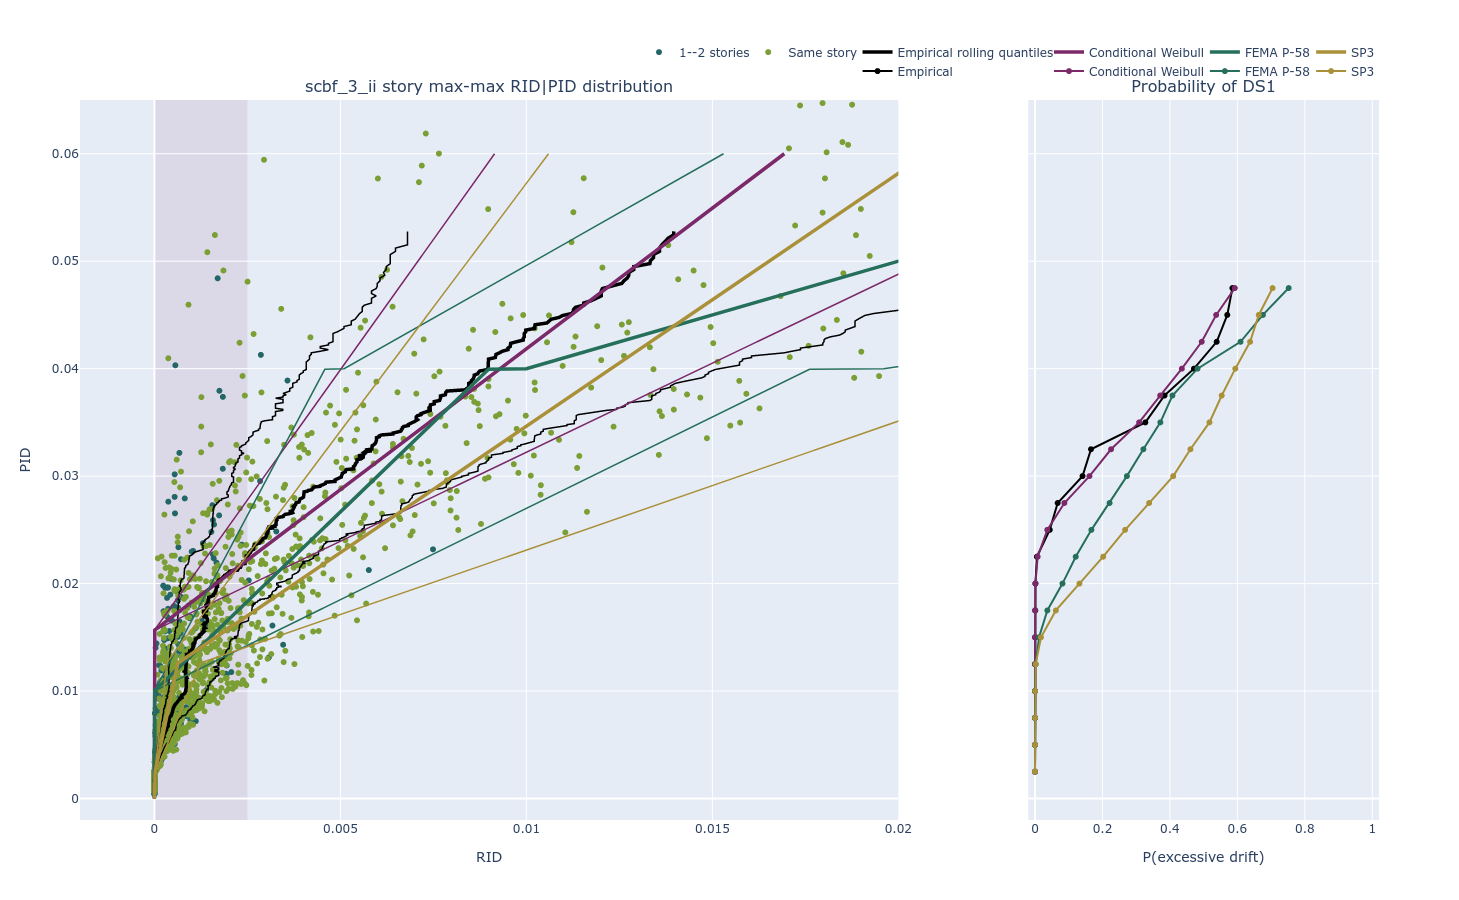

In [ ]:

# functions


def get_pid_rid_pairs(system, stories, rc, story):
    """
    Retrieves PID-RID pairs for the given case.

    Parameters
    ----------
    system: str
        Any of {smrf, scbf, brbf}
    stories: str
        Any of {3, 6, 9}
    rc: str
        Any of {ii, iv}
    direction: str
        Any of {x, y}
    story: str
        Any of {1, 2, ..., stories} or 'max-max'

    Returns
    -------
    tuple or pd.DataFrame
        If a location is given, returns:
        - Dataframe with PID-RID pairs, with unstable collapse cases
        removed (transient drift exceeding 10%).
        - RSN of each pair.
        - Applied scaling factor.
        If the location is max-max:
        - Dataframe with maxPID-maxRID pairs, with unstable collapse
        cases removed (transient drift exceeding 10%), and
        descriptions of the story where the max values occurred.

    """

    archetype = f'{system}_{stories}_{rc}'
    df_archetype = df.loc[archetype, :]

    # remove cases where PID > 0.10 (unstable collapse)
    pairs_all_stories = (
        df_archetype.loc[
            slice(None),
            ['PID', 'RID'],
            slice(None),
            slice(None),
            slice(None),
        ]
        .unstack('edp')
        .unstack('loc')
    )
    collapse_bool = (pairs_all_stories[('value', 'PID')] > 0.10).any(axis=1).values
    pairs_all_stories = pairs_all_stories.iloc[~collapse_bool, :]

    if story == 'max-max':
        pid = {}
        pid_story = {}
        rid = {}
        rid_story = {}
        for direction in ('x', 'y'):
            pid[direction] = pairs_all_stories.loc[direction, ('value', 'PID')]
            pid[direction].columns = pid[direction].columns.astype(int)
            pid_story[direction] = pid[direction].idxmax(axis=1)
            pid[direction] = pid[direction].max(axis=1)
            rid[direction] = pairs_all_stories.loc[direction, ('value', 'RID')]
            rid[direction].columns = rid[direction].columns.astype(int)
            rid_story[direction] = rid[direction].idxmax(axis=1)
            rid[direction] = rid[direction].max(axis=1)
        pid = pd.concat((pid['x'], pid['y']), keys=('x', 'y'))
        rid = pd.concat((rid['x'], rid['y']), keys=('x', 'y'))
        pid_story = pd.concat((pid_story['x'], pid_story['y']), keys=('x', 'y'))
        rid_story = pd.concat((rid_story['x'], rid_story['y']), keys=('x', 'y'))

        pairs = pd.concat(
            (pid, rid, pid_story, rid_story),
            keys=['PID', 'RID', 'PIDStory', 'RIDStory'],
            axis=1,
        )
        pairs.index.names = ['dir', *pairs.index.names[1:]]
        pairs = pairs.reset_index()

        # Partitioning used for plotting
        pairs['StoryDiff'] = (pairs['PIDStory'] - pairs['RIDStory']).abs()
        pairs['StoryDiffText'] = ''
        pairs.loc[pairs['StoryDiff'] == 0, 'StoryDiffText'] = 'Same story'
        pairs.loc[pairs['StoryDiff'] == 1, 'StoryDiffText'] = '1--2 stories'
        pairs.loc[pairs['StoryDiff'] == 2, 'StoryDiffText'] = '1--2 stories'
        pairs.loc[pairs['StoryDiff'] > 2, 'StoryDiffText'] = '>2 stories'
        for thing in {'PIDStory', 'RIDStory'}:
            pairs[f'{thing}Text'] = 'Intermediate stories'
            if stories == '3':
                pairs.loc[pairs[thing] <= 2, f'{thing}Text'] = 'First 2 stories'
            else:
                pairs.loc[pairs[thing] <= 3, f'{thing}Text'] = 'First 3 stories'
            pairs.loc[pairs[thing] == int(stories), f'{thing}Text'] = 'Last story'

        return pairs

    # # stack locations
    # pairs = pairs_all_stories.stack('loc', future_stack=True)

    else:

        # filter story
        pairs = pairs_all_stories.iloc[
            :, pairs_all_stories.columns.get_level_values('loc') == story
        ]
        pairs.columns = pairs.columns.droplevel('loc')

        pairs = pairs.dropna(how='any')
        rsns = pairs['rsn']['PID']
        scaling = pairs['scaling_factor']['PID']
        pairs = pairs.loc[:, 'value']
        pairs = pairs.reset_index()

        return pairs, rsns, scaling


if story == 'max-max':
    pairs = get_pid_rid_pairs(system, stories, rc, story)
else:
    pairs, rsn_data, scale_data = get_pid_rid_pairs(system, stories, rc, story)


roll = models.Model()
roll.add_data(pairs['PID'].values, pairs['RID'].values)
roll.censoring_limit = 0.0025
roll.calculate_rolling_quantiles()

pelicun_fitted_model = selected_model
weibull_subset = pairs
weibull_subset = weibull_subset[weibull_subset['PID'] > 0.02]
pelicun_fitted_model.add_data(
    weibull_subset['PID'].values, weibull_subset['RID'].values
)
pelicun_fitted_model.censoring_limit = 0.0025
pelicun_fitted_model.fit(method='mle')

model_pid = np.linspace(0.00, 0.06, 1000)
model_rid_50 = pelicun_fitted_model.evaluate_inverse_cdf(0.50, model_pid)
model_rid_20 = pelicun_fitted_model.evaluate_inverse_cdf(0.20, model_pid)
model_rid_80 = pelicun_fitted_model.evaluate_inverse_cdf(0.80, model_pid)

fema_model = models.Model_P58()
fema_model.set(delta_y=0.01, beta=0.80)

fema_model_rid_50 = fema_model.evaluate_inverse_cdf(0.50, model_pid)
fema_model_rid_20 = fema_model.evaluate_inverse_cdf(0.20, model_pid)
fema_model_rid_80 = fema_model.evaluate_inverse_cdf(0.80, model_pid)

sp3_model = models.Model_SP3()
sp3_model.set(model_option='brbf_backup', delta_y=0.0021, dispersion=0.8)

sp3_model_rid_50 = sp3_model.evaluate_inverse_cdf(0.50, model_pid)
sp3_model_rid_20 = sp3_model.evaluate_inverse_cdf(0.20, model_pid)
sp3_model_rid_80 = sp3_model.evaluate_inverse_cdf(0.80, model_pid)

c0 = '#7C296A'
c1 = '#256F5B'
c2 = '#AA9139'

# Probability of excessive drift
pid_conditioning_values = np.arange(0.0025, 0.08, 0.0025)
halfwidth = 0.002
prob_empirical = []
prob_weibull = []
prob_fema = []
prob_sp3 = []

num_realizations = 10000
for i, val in enumerate(pid_conditioning_values):
    subset_pairs = pairs
    subset_pairs = subset_pairs[subset_pairs['PID'] > val - halfwidth]
    subset_pairs = subset_pairs[subset_pairs['PID'] < val + halfwidth]
    if len(subset_pairs) < 20:
        prob_empirical.append(np.nan)
        prob_weibull.append(np.nan)
        prob_fema.append(np.nan)
        prob_sp3.append(np.nan)
    else:
        pid_array = np.random.choice(
            subset_pairs['PID'].values, size=num_realizations, replace=True
        )
        capacities = rid_capacity_delta * np.exp(
            rid_capacity_beta * norm.rvs(size=num_realizations)
        )
        rids_empirical = np.random.choice(
            subset_pairs['RID'].values, size=num_realizations, replace=True
        )
        rids_weibull = pelicun_fitted_model.generate_rid_samples(pid_array)
        rids_fema = fema_model.generate_rid_samples(pid_array)
        rids_sp3 = sp3_model.generate_rid_samples(pid_array)
        prob_empirical.append(
            sum(rids_empirical > capacities) / float(num_realizations)
        )
        prob_weibull.append(sum(rids_weibull > capacities) / float(num_realizations))
        prob_fema.append(sum(rids_fema > capacities) / float(num_realizations))
        prob_sp3.append(sum(rids_sp3 > capacities) / float(num_realizations))


fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    column_widths=[0.7, 0.3],
    subplot_titles=(
        f'{system}_{stories}_{rc} story {story} RID|PID distribution',
        'Probability of DS1',
    ),
)

if story == 'max-max':
    categories = pairs[criterion].unique()

    palette = {
        'Same story': "#7B9F35",
        '1--2 stories': "#226666",
        '>2 stories': "#AA3939",
        'First 2 stories': "#7B9F35",
        'First 3 stories': "#7B9F35",
        'Intermediate stories': "#226666",
        'Last story': "#226666",
    }

    for category in categories:

        custom_data = list(
            zip(
                pairs[pairs[criterion] == category]['dir'],
                pairs[pairs[criterion] == category]['hz'],
                pairs[pairs[criterion] == category]['PIDStory'],
                pairs[pairs[criterion] == category]['RIDStory'],
            )
        )
        hovertemplate = (
            'RID: %{x}<br>'
            'PID: %{y}<br>'
            'DIR: %{customdata[0]}<br>'
            'HZLVL: %{customdata[1]}<br>'
            'PID Story: %{customdata[2]}<br>'
            'RID Story: %{customdata[3]}<extra></extra>'
        )

        fig.add_trace(
            go.Scatter(
                x=pairs[pairs[criterion] == category]['RID'],
                y=pairs[pairs[criterion] == category]['PID'],
                mode='markers',
                marker=dict(
                    color=palette[category],
                ),
                name=category,
                customdata=custom_data,
                hovertemplate=hovertemplate,
            ),
            row=1,
            col=1,
        )


else:
    custom_data = list(zip(pairs['dir'], pairs['hz'], rsn_data, scale_data))
    hovertemplate = (
        'RID: %{x}<br>'
        'PID: %{y}<br>'
        'DIR: %{customdata[0]}<br>'
        'HZLVL: %{customdata[1]}<br>'
        'RSN: %{customdata[2]}<br>'
        'SF: %{customdata[3]}<extra></extra>'
    )

    fig.add_trace(
        go.Scatter(
            x=pairs['RID'],
            y=pairs['PID'],
            mode='markers',
            marker=dict(
                symbol='cross-thin-open',
                color='gray',
                size=6,
                opacity=0.90,
            ),
            name='Scatter Data',
            customdata=custom_data,
            hovertemplate=hovertemplate,
        ),
        row=1,
        col=1,
    )


empirical_data = [
    (roll.rolling_rid_50, roll.rolling_pid, 3.5, True),
    (roll.rolling_rid_20, roll.rolling_pid, 1.5, False),
    (roll.rolling_rid_80, roll.rolling_pid, 1.5, False),
]

cw_data = [
    (model_rid_50, model_pid, 3.5, True),
    (model_rid_20, model_pid, 1.5, False),
    (model_rid_80, model_pid, 1.5, False),
]

fema_data = [
    (fema_model_rid_50, model_pid, 3.5, True),
    (fema_model_rid_20, model_pid, 1.5, False),
    (fema_model_rid_80, model_pid, 1.5, False),
]

sp3_data = [
    (sp3_model_rid_50, model_pid, 3.5, True),
    (sp3_model_rid_20, model_pid, 1.5, False),
    (sp3_model_rid_80, model_pid, 1.5, False),
]


def add_traces(data, color, name, legendgroup):
    for x, y, width, showlegend in data:
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode='lines',
                line={'color': color, 'width': width},
                name=name if showlegend else None,
                showlegend=showlegend,
                legendgroup=legendgroup,
            ),
            row=1,
            col=1,
        )


add_traces(empirical_data, 'black', 'Empirical rolling quantiles', 'erq')
add_traces(cw_data, c0, 'Conditional Weibull', 'cw')
add_traces(fema_data, c1, 'FEMA P-58', 'fm')
add_traces(sp3_data, c2, 'SP3', 'sp3')

# Shade censoring limit region
fig.add_shape(
    type="rect",
    x0=0.00,
    y0=ymin,
    x1=roll.censoring_limit,
    y1=ymax,
    fillcolor=c0,
    opacity=0.1,
    layer="below",
    line_width=0,
    row=1,
    col=1,
)

fig.update_xaxes(range=[xmin, xmax], row=1, col=1)
fig.update_yaxes(range=[ymin, ymax], row=1, col=1)
fig.update_xaxes(range=[-0.02, 1.02], row=1, col=2)
fig.update_yaxes(range=[ymin, ymax], row=1, col=2)

for xvals, name, color, legendgroup in zip(
    (prob_empirical, prob_weibull, prob_fema, prob_sp3),
    ('Empirical', 'Conditional Weibull', 'FEMA P-58', 'SP3'),
    ('black', c0, c1, c2),
    ('erq', 'cw', 'fm', 'sp3'),
):

    fig.add_trace(
        go.Scatter(
            x=xvals,
            y=pid_conditioning_values,
            mode='lines+markers',
            name=name,
            marker=dict(color=color),
            line=dict(color=color),
            legendgroup=legendgroup,
        ),
        row=1,
        col=2,
    )

fig.update_layout(
    barmode='group',
    bargap=0.60,
)

# Update layout to position the legend at the top
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    height=900
)

fig.update_xaxes(title_text="RID", row=1, col=1)
fig.update_yaxes(title_text="PID", row=1, col=1)
fig.update_xaxes(title_text="P(excessive drift)", row=1, col=2)

fig.show()